# Particle Swarm Optimization (PSO)-based Surveillance


## Setup

In [34]:
%matplotlib widget
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
from datetime import datetime, timedelta
start_time = datetime.now()

## Target Model

In [36]:
from stonesoup.models.transition.linear import CombinedLinearGaussianTransitionModel, ConstantVelocity, SingerApproximate
import numpy as np

transition_model = CombinedLinearGaussianTransitionModel([
    ConstantVelocity(0),
    ConstantVelocity(0),
    # SingerApproximate(10, 1),
    # SingerApproximate(10, 1),
    ConstantVelocity(0),
])

## Radar System

In [37]:
from mpar_sim.radar import PhasedArrayRadar
from mpar_sim.beam.beam import RectangularBeam, GaussianBeam
from mpar_sim.looks.look import Look
from mpar_sim.resource_management import PAPResourceManager
from mpar_sim.schedulers import BestFirstScheduler
import numpy as np

radar = PhasedArrayRadar(
    ndim_state=transition_model.ndim_state,
    position_mapping=(0, 2, 4),
    velocity_mapping=(1, 3, 5),
    position=np.array([[0], [0], [0]]),
    rotation_offset=np.array([[0], [0], [0]]),
    # Array parameters
    n_elements_x=32,
    n_elements_y=32,
    element_spacing=0.5,  # Wavelengths
    element_tx_power=10,
    # System parameters
    center_frequency=3e9,
    system_temperature=290,
    noise_figure=4,
    # Scan settings
    beam_shape=RectangularBeam,
    az_fov=[-60, 60],
    el_fov=[-60, 60],
    # Detection settings
    false_alarm_rate=1e-6,
    include_false_alarms=False
)
radar.timestamp = start_time

manager = PAPResourceManager(radar,
                             max_duty_cycle=0.1,
                             max_bandwidth=100e6)
scheduler = BestFirstScheduler(manager,
                               sort_key="start_time",
                               reverse_sort=False,
                               max_time_delta=timedelta(seconds=2))

Raster scan agent

In [38]:
from mpar_sim.agents.raster_scan import RasterScanAgent
import numpy as np

search_agent = RasterScanAgent(
    azimuth_scan_limits=np.array([-45, 45]),
    elevation_scan_limits=np.array([-45, 45]),
    azimuth_beam_spacing=0.80,
    elevation_beam_spacing=0.80,
    azimuth_beamwidth=15,
    elevation_beamwidth=15,
    bandwidth=100e6,
    pulsewidth=1e-6,
    prf=5e3,
    n_pulses=100,
)

## Tracker Components

## PSO Optimizer

In [39]:
from mpar_sim.particle.global_best import IncrementalGlobalBestPSO
import matplotlib.pyplot as plt

# Set-up hyperparameters
options = {'c1': 0.2, 'c2': 0.5, 'w': 0.9}

pso = IncrementalGlobalBestPSO(n_particles=1000,
                               dimensions=2,
                               options=options,
                               bounds=([-45, -45], [45, 45]),
                               )

# plt.plot(pso.swarm.position[:, 0], pso.swarm.position[:, 1], 'o')

Objective function definition

Here, the objective is the Euclidean distance between each particle and the latest detection. This will probably not be robust to false alarms, but it should work as a first-pass

In [40]:
def distance_objective(swarm_pos, detection_pos):
  return np.linalg.norm(swarm_pos - detection_pos, axis=1)


## Run the Simulation

In [41]:
from typing import Set, List
from stonesoup.types.groundtruth import GroundTruthPath, GroundTruthState
import datetime

def move(truths: List[GroundTruthPath], 
         reference_time: datetime.datetime, 
         current_time: datetime.datetime):
  """
  Interpolate each target in the list to the current time without noise. This is used to propagate the target position between waypoints/global simulation updates.
  """
  current_truths = []
  dt = current_time - reference_time
  for truth in truths:
    if radar.is_detectable(truth[-1]):
      state = GroundTruthState(
          transition_model.function(truth[-1],
                                    noise=False,
                                    time_interval=dt),
          timestamp=reference_time)
      truth.append(GroundTruthPath([state]))
      current_truths.append(truth)

  return current_truths

In [42]:
import copy
import operator
from stonesoup.types.groundtruth import GroundTruthPath, GroundTruthState
from stonesoup.types.array import CovarianceMatrix
from stonesoup.types.state import StateVector, GaussianState
import random
from stonesoup.simulator.simple import MultiTargetGroundTruthSimulator
from mpar_sim.simulator.simple import MultiTargetScenario
from mpar_sim.looks.volume_search import VolumeSearchLook

# Set the simulation seed
seed = np.random.randint(0, 2**32-1)

# Simulation-level parameters
include_noise = True

# Target generation parameters
if radar.ndim_state == 6:
  initial_state_mean = StateVector([1500, 10, 0, 0, 0, 0])
  initial_state_covariance = CovarianceMatrix(
      np.diag([200, 10, 200, 20, 500, 10]))
elif radar.ndim_state == 8:
  initial_state_mean = StateVector([10e3, 10, 0, 0, 0, 0, 0, 0])
  initial_state_covariance = CovarianceMatrix(
      np.diag([1000, 50, 10, 1000, 50, 5, 0, 0]))
initial_state = GaussianState(
    initial_state_mean, initial_state_covariance, timestamp=start_time)

target_rcs = 10

scenario = MultiTargetScenario(
    transition_model=transition_model,
    initial_state=initial_state,
    timestep=timedelta(seconds=0),
    number_steps=1000,
    birth_rate=0,
    death_probability=0,
    seed=seed,
    initial_number_targets=5,
)


# Simulation state information
truths = []
all_truths = set()
confirmed_tracks = set()
tentative_tracks = set()
all_measurements = []
all_tracks = set()

# Metrics
n_truths = []
n_tentative_tracks = []
n_confirmed_tracks = []
position_accuracy = []
velocity_accuracy = []
times = []

# Simulation time variables.
time = start_time
scheduler_time = start_time
for time, truths in scenario:

  ########################################
  # Simulate the current look
  ########################################
  if manager.allocated_tasks:
    look = manager.allocated_tasks.pop()
    scheduler_time = look.end_time
    radar.load_look(look)
    if look.start_time > time:
      # Interpolate targets to the start of the look
      current_truths = move(truths, time, look.start_time)
    else:
      current_truths = truths
    # Also add the current RCS to the target truth
    for truth in current_truths:
      truth.states[-1].rcs = target_rcs

    detections = radar.measure(current_truths, noise=include_noise)
    
    for det in detections:
      az = det.state_vector[1].degrees
      el = det.state_vector[0].degrees
      pso.optimize(distance_objective, detection_pos=np.array([az, el]))

    # Update scenario information
    all_truths |= truths
    all_tracks |= confirmed_tracks
    all_measurements.append(detections)

    # Update metrics
    times.append(look.start_time)
    n_truths.append(len(current_truths))
    
  ########################################
  # Allocate resources
  ########################################
  # Generate looks from each agent
  search_looks = search_agent.act(current_time=scheduler_time, n_looks=1)

  looks = search_looks

  # Schedule new looks, sorted so that the task with the nearest end time is selected first below
  scheduler.schedule(looks, scheduler_time)
  manager.allocated_tasks.sort(
      key=operator.attrgetter("end_time"), reverse=True)

  ########################################
  # Update scenario
  ########################################
  # Minimum start time of all scheduled tasks. When this changes, a new "batch" of tasks has been allocated and the scenario needs to be updated
  min_start_time = min([task.start_time for task in manager.allocated_tasks]
                       ) if manager.allocated_tasks else time

  scenario.timestep = min_start_time - time

## Analyze Simulation Results

2022-12-05 13:59:38,512 - matplotlib.animation - INFO - Animation.save using <class 'matplotlib.animation.ImageMagickWriter'>
2022-12-05 13:59:38,514 - matplotlib.animation - INFO - MovieWriter._run: running command: convert -size 1000x800 -depth 8 -delay 10.0 -loop 0 rgba:- -layers OptimizePlus plot0.gif


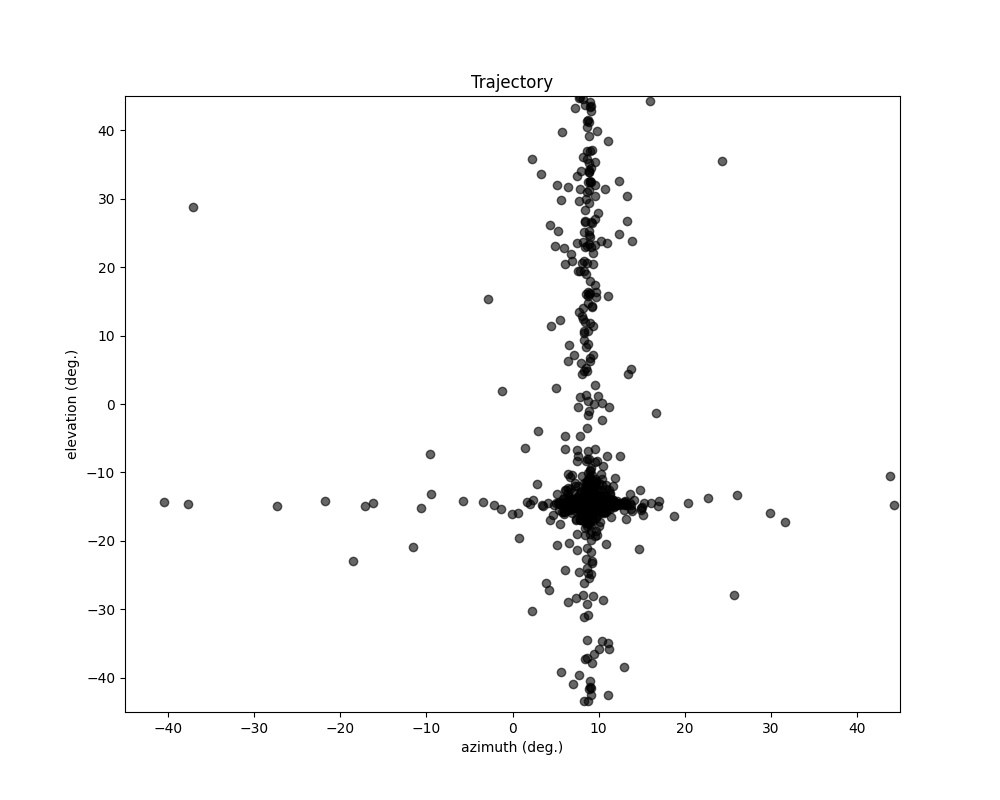

In [43]:
from pyswarms.utils.functions import single_obj as fx
from pyswarms.utils.plotters import (plot_cost_history, plot_contour, plot_surface)
from pyswarms.utils.plotters.formatters import Mesher
from pyswarms.utils.plotters.formatters import Designer
d = Designer(limits=[(-45,45), (-45,45)], label=['azimuth (deg.)', 'elevation (deg.)'])

# m = Mesher(func=fx.sphere)
# display(pso.pos_history)
animation = plot_contour(pos_history=pso.pos_history,
                         designer=d,)
animation.save('plot0.gif', writer='imagemagick', 
               fps=10)
# pso.pos_history                         

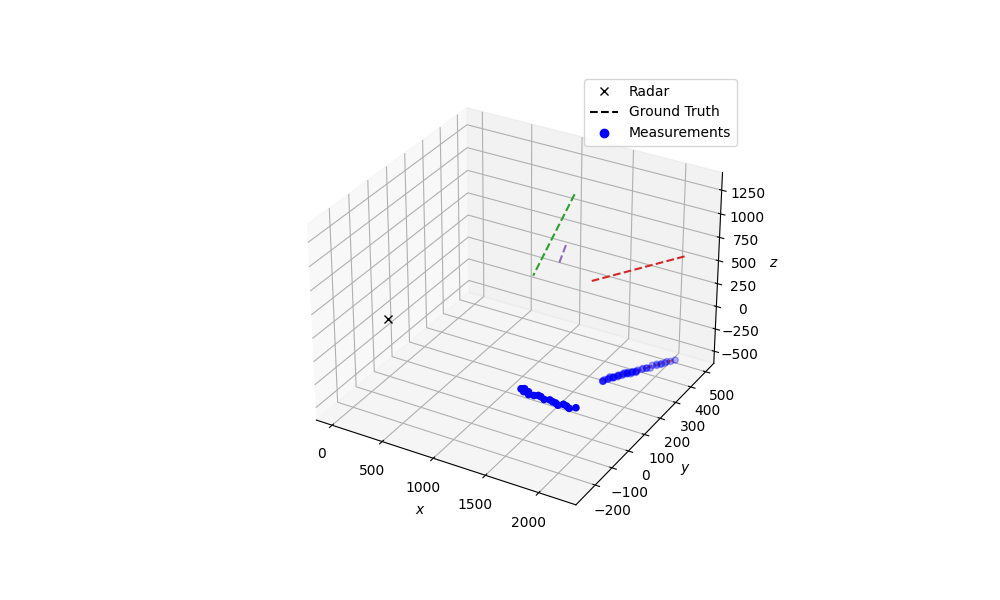

In [44]:
from stonesoup.plotter import Plotter, Dimension


plotter = Plotter(Dimension.THREE)
plotter.plot_sensors(radar, "Radar")
plotter.plot_ground_truths(all_truths, radar.position_mapping)
plotter.plot_measurements(all_measurements, radar.position_mapping)
# plotter.plot_tracks(all_tracks, radar.position_mapping)
# plotter.fig